In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/MSU/VKR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MSU/VKR


In [ ]:
import numpy as np
import pickle


from my_utils import *
from data_utils_PENN import visualize, load_PENN_data

autoenc_X, autoenc_Y = load_PENN_data(None, True, True)

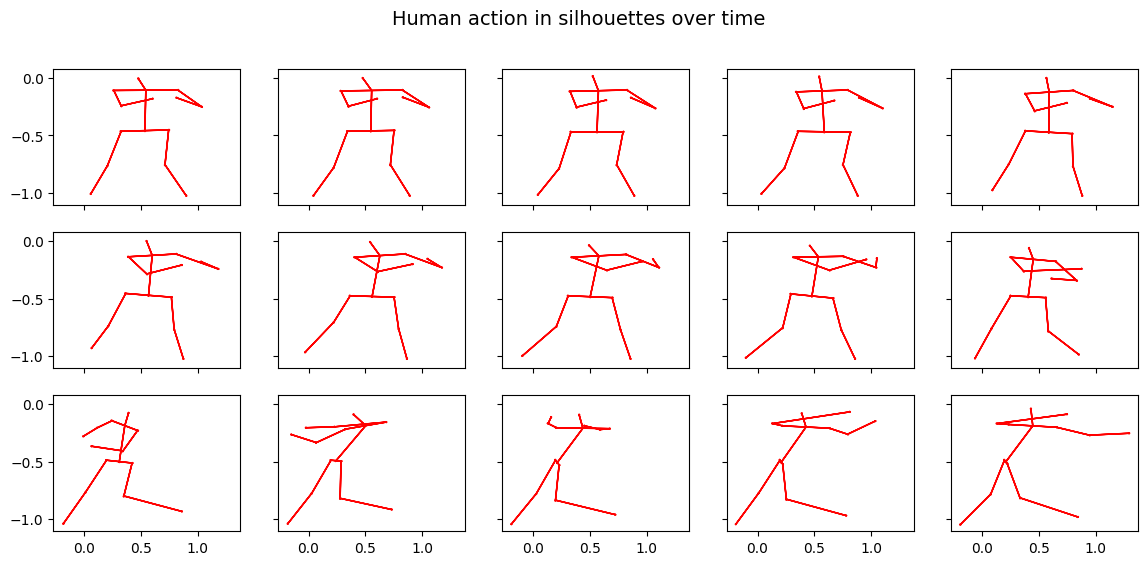

In [ ]:
visualize(autoenc_X[0])

In [ ]:
n_samples =  autoenc_X.shape[0]
train_samples = int(n_samples * .8)

transforms =[basic_series_transform(AdjustedNormTimeWarp(0.1, 5), prob=.8),
              basic_series_transform(NormJittering(0.053), prob=1.0),
              basic_series_transform(Jittering(0.05), prob=1.0), autoenc_transform()]  # training

train_dataset_tmp = SimpleDataset(autoenc_X[:train_samples],
                         autoenc_Y[:train_samples],
                         transforms)


test_dataset = SimpleDataset(autoenc_X[train_samples:],
                              autoenc_Y[train_samples:],
                             [autoenc_transform()])

# We will take a slightly different route for train dataloader
test_loader = DataLoader(test_dataset, batch_size = 61, shuffle = False)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
import torch
import os
from torch.utils.data import TensorDataset, DataLoader



# A trick to build a new dataset once to save time from transforms
def build_offline_dataset(dataset_, repeats=100, out_path="augmented.pt"):
    all_X = []
    all_Y = []
    for _ in range(repeats):
        for obj in dataset_:
            x_aug, y = obj
            all_X.append(x_aug[None, :, :])
            all_Y.append(y[None, :])
    # stack into two big tensors
    X_big = torch.Tensor(np.concatenate(all_X, axis=0))
    Y_big = torch.Tensor(np.concatenate(all_Y, axis=0))
    torch.save((X_big, Y_big), out_path)
    print(f"Saved augmented dataset ({len(all_X)} samples) to {out_path}")


if not os.path.exists("train_aug.pt"):
    # --- Pre-compute & save ---
    build_offline_dataset(
        train_dataset_tmp,
        repeats=100,
        out_path="train_aug.pt"
    )


# --- Later: reload & wrap in a Dataset ---
X_big, Y_big = torch.load("train_aug.pt")
offline_ds = TensorDataset(X_big, Y_big)
train_loader = DataLoader(offline_ds, batch_size=61, shuffle=True)

In [ ]:
from my_AE_models import STLStructuredAutoencoder, train_autoenc

encoder_kwargs = kwargs = {
    'aux_dim': 400,
    'int_dim': 64,
    'd': 64,
    'k': 10,
    'denom': 1,
    'L': 30,
    'm': 26,
    'poly': 12,
    'device': device
}

decoder_kwargs = {
    'L': 30,
    'M': 26,
    'n': 30,        # computed as 1 * 1 * L // 1
    'denom': 1,
    'poly': 12,
    'd': 64,
    'aux_enc': 1028,
    'aux_dec': 1028,
    'device': device
}


ae_model = STLStructuredAutoencoder(encoder_kwargs, **decoder_kwargs).to(device).float()

ae_loss_fn = lambda x, y: nn.MSELoss()(x,y)

In [ ]:
from torch import optim
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(ae_model.parameters(), lr=7e-5)

scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

# Note that most transformtations slow down the training a lot.
# But they improve the quality drastically

train_history, test_history = train_autoenc(ae_model, device, train_loader, test_loader, 100, optimizer, scheduler, ae_loss_fn)

Epoch 1 ▶ Training Loss: 0.0121


           Test Loss:     0.0036


Epoch 2 ▶ Training Loss: 0.0058


           Test Loss:     0.0034


Epoch 3 ▶ Training Loss: 0.0057


           Test Loss:     0.0034


Epoch 4 ▶ Training Loss: 0.0056


           Test Loss:     0.0033


Epoch 5 ▶ Training Loss: 0.0056


           Test Loss:     0.0032


Epoch 6 ▶ Training Loss: 0.0055


           Test Loss:     0.0031


Epoch 7 ▶ Training Loss: 0.0054


           Test Loss:     0.0030


Epoch 8 ▶ Training Loss: 0.0054


           Test Loss:     0.0030


Epoch 9 ▶ Training Loss: 0.0053


           Test Loss:     0.0030


Epoch 10 ▶ Training Loss: 0.0053


           Test Loss:     0.0029


Epoch 11 ▶ Training Loss: 0.0052


           Test Loss:     0.0029


Epoch 12 ▶ Training Loss: 0.0051


           Test Loss:     0.0027


Epoch 13 ▶ Training Loss: 0.0051


           Test Loss:     0.0027


Epoch 14 ▶ Training Loss: 0.0050


           Test Loss:     0.0027


Epoch 15 ▶ Training Loss: 0.0050


           Test Loss:     0.0027


Epoch 16 ▶ Training Loss: 0.0049


           Test Loss:     0.0025


Epoch 17 ▶ Training Loss: 0.0049


           Test Loss:     0.0025


Epoch 18 ▶ Training Loss: 0.0048


           Test Loss:     0.0025


Epoch 19 ▶ Training Loss: 0.0048


           Test Loss:     0.0025


Epoch 20 ▶ Training Loss: 0.0047


           Test Loss:     0.0024


Epoch 21 ▶ Training Loss: 0.0047


           Test Loss:     0.0023


Epoch 22 ▶ Training Loss: 0.0046


           Test Loss:     0.0023


Epoch 23 ▶ Training Loss: 0.0046


           Test Loss:     0.0023


Epoch 24 ▶ Training Loss: 0.0046


           Test Loss:     0.0022


Epoch 25 ▶ Training Loss: 0.0045


           Test Loss:     0.0022


Epoch 26 ▶ Training Loss: 0.0045


           Test Loss:     0.0021


Epoch 27 ▶ Training Loss: 0.0044


           Test Loss:     0.0021


Epoch 28 ▶ Training Loss: 0.0044


           Test Loss:     0.0021


Epoch 29 ▶ Training Loss: 0.0044


           Test Loss:     0.0021


Epoch 30 ▶ Training Loss: 0.0044


           Test Loss:     0.0021


Epoch 31 ▶ Training Loss: 0.0043


           Test Loss:     0.0020


Epoch 32 ▶ Training Loss: 0.0043


           Test Loss:     0.0020


Epoch 33 ▶ Training Loss: 0.0043


           Test Loss:     0.0020


Epoch 34 ▶ Training Loss: 0.0042


           Test Loss:     0.0020


Epoch 35 ▶ Training Loss: 0.0042


           Test Loss:     0.0020


Epoch 36 ▶ Training Loss: 0.0042


           Test Loss:     0.0019


Epoch 37 ▶ Training Loss: 0.0042


           Test Loss:     0.0019


Epoch 38 ▶ Training Loss: 0.0042


           Test Loss:     0.0019


Epoch 39 ▶ Training Loss: 0.0041


           Test Loss:     0.0019


Epoch 40 ▶ Training Loss: 0.0041


           Test Loss:     0.0019


Epoch 41 ▶ Training Loss: 0.0041


           Test Loss:     0.0019


Epoch 42 ▶ Training Loss: 0.0041


           Test Loss:     0.0019


Epoch 43 ▶ Training Loss: 0.0041


           Test Loss:     0.0019


Epoch 44 ▶ Training Loss: 0.0041


           Test Loss:     0.0018


Epoch 45 ▶ Training Loss: 0.0040


           Test Loss:     0.0018


Epoch 46 ▶ Training Loss: 0.0040


           Test Loss:     0.0018


Epoch 47 ▶ Training Loss: 0.0040


           Test Loss:     0.0018


Epoch 48 ▶ Training Loss: 0.0040


           Test Loss:     0.0018


Epoch 49 ▶ Training Loss: 0.0040


           Test Loss:     0.0018


Epoch 50 ▶ Training Loss: 0.0040


           Test Loss:     0.0018


Epoch 51 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 52 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 53 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 54 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 55 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 56 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 57 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 58 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 59 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 60 ▶ Training Loss: 0.0039


           Test Loss:     0.0018


Epoch 61 ▶ Training Loss: 0.0038


           Test Loss:     0.0018


Epoch 62 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 63 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 64 ▶ Training Loss: 0.0038


           Test Loss:     0.0018


Epoch 65 ▶ Training Loss: 0.0038


           Test Loss:     0.0018


Epoch 66 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 67 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 68 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 69 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 70 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 71 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 72 ▶ Training Loss: 0.0038


           Test Loss:     0.0017


Epoch 73 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 74 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 75 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 76 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 77 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 78 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 79 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 80 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 81 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 82 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 83 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 84 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 85 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 86 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 87 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 88 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 89 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 90 ▶ Training Loss: 0.0037


           Test Loss:     0.0017


Epoch 91 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 92 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 93 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 94 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 95 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 96 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 97 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 98 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 99 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


Epoch 100 ▶ Training Loss: 0.0036


           Test Loss:     0.0017


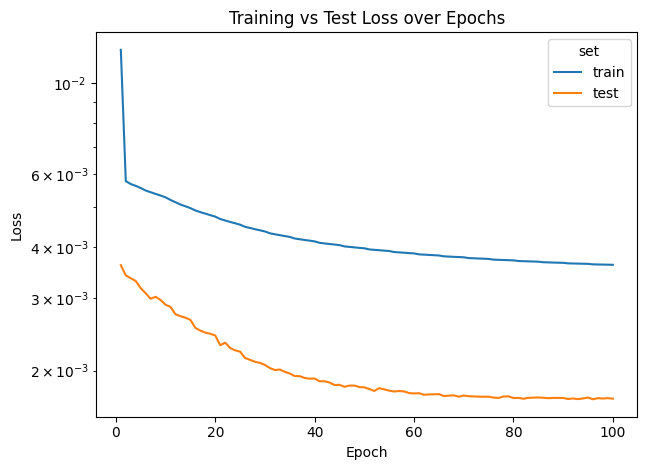

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

records = []
records += [
    {'epoch': epoch, 'loss': loss, 'set': 'train'}
    for epoch, loss in enumerate(train_history['loss'], start=1)
]
if test_history.get('loss'):
    records += [
        {'epoch': epoch, 'loss': loss, 'set': 'test'}
        for epoch, loss in enumerate(test_history['loss'], start=1)
    ]

df = pd.DataFrame(records)

# Plot both on the same graph
plt.figure()
sns.lineplot(data=df, x='epoch', y='loss', hue='set')
plt.title('Training vs Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.yscale('log')
plt.show()

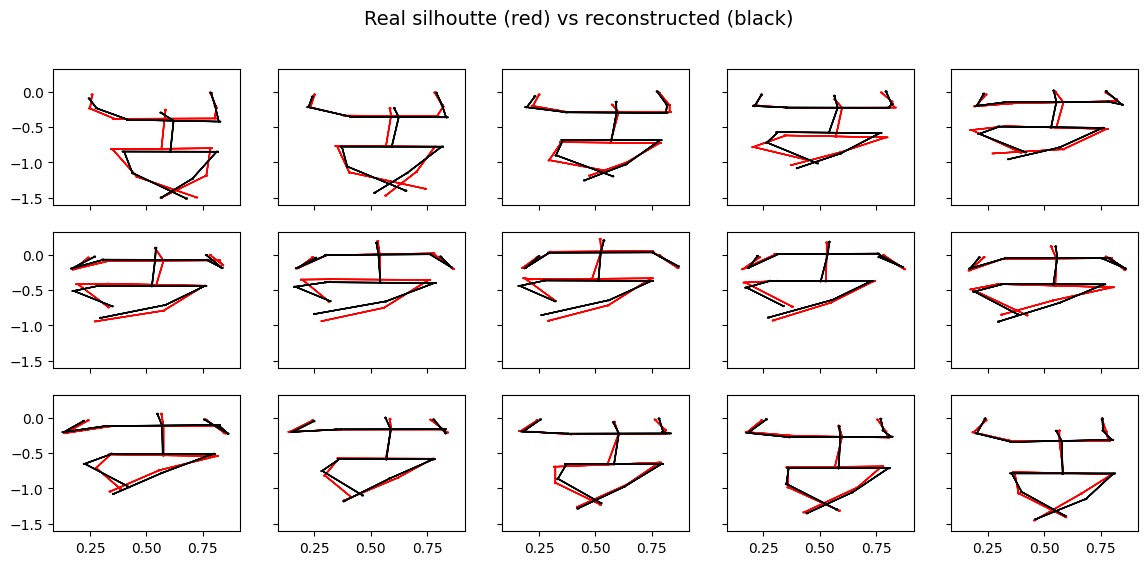

In [ ]:
ae_model.eval()
test_examples = next(iter(test_loader))[0].float().to(device)
test_decoded = ae_model.forward(test_examples)
visualize(test_examples[1].detach().cpu().numpy(), test_decoded[1].detach().cpu().numpy(), 'Real silhoutte (red) vs reconstructed (black)')

In [ ]:
ae_model.eval()
true_, restored_ = [], []
for x in test_loader:
    true_.append(x[0].detach().cpu().numpy())
    restored_.append(ae_model(x[0].float().to(device)).detach().cpu().numpy())

true_ = np.concatenate(true_).reshape(-1, 30*26)
restored_ = np.concatenate(restored_).reshape(-1, 30*26)

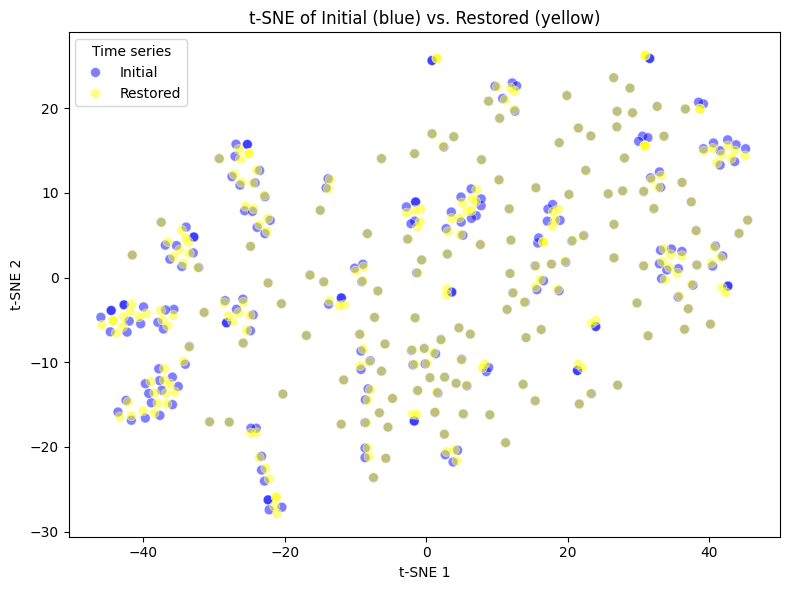

In [ ]:
from sklearn.manifold import TSNE


data_all = np.vstack((true_, restored_))
tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(data_all)

# build a DataFrame with labels
labels = ['Initial'] * len(true_) + ['Restored'] * len(restored_)
df = pd.DataFrame({
    'TSNE1': proj[:, 0],
    'TSNE2': proj[:, 1],
    'Dataset': labels
})

# single seaborn scatterplot with hue
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='TSNE1', y='TSNE2',
    hue='Dataset',
    palette={'Initial': 'blue', 'Restored': 'yellow'},
    s=50,      # marker size
    alpha=0.5
)
plt.title('t-SNE of Initial (blue) vs. Restored (yellow)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Time series')
plt.tight_layout()
plt.show()

In [ ]:
with open('autoenc_model.pkl', 'wb') as f:
    pickle.dump(ae_model, f)